In [17]:
import numpy as np
# %pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from typing import Tuple
from matplotlib import pyplot as plt

In [19]:
FEATURES_FILE = "processed_data.npz" 
TEST_SIZE = 0.2  
VALIDATION_SPLIT = 0.1  # 25% of the remaining 80% is 20% overall (Train 60%, Val 20%)
EPOCHS = 100
BATCH_SIZE = 32
RANDOM_STATE = 42
MODEL_FILENAME = 'cnn_speech_commands.h5'
TEST_SET_FILENAME = 'X_test_y_test_features.npz'
HISTORY_FILENAME = 'training_history.npz'

In [18]:
def load_data(filepath: str) -> tuple[np.ndarray, np.ndarray, np.ndarray] | tuple[None, None, None]:
    data = np.load(filepath, allow_pickle=True)
    try:
        # Note: Your previous run saved 'X', 'y', and 'label_names'
        X, y, label_names = data['X'], data['y'], data['label_names']
    except Exception as e:
        print(f"Error loading data: {e}. Check key names in the .npz file.")
        return None, None, None
    print(f"Loaded data: {X.shape[0]} samples, {len(label_names)} classes. Feature shape: {X.shape[1:]}")
    return X, y, label_names

def preprocess_and_split(X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int]:
    
    # 1. Normalization (as per your script)
    max_val = np.abs(X).max()
    X_norm = X / max_val
    print(f"Features normalized by dividing by max absolute value: {max_val:.2f}")

    # 2. Reshaping for CNN (Adding the channel dimension, if not already there)
    # The feature extraction already put it at the end (1000, 64, 67, 1), so this may be redundant,
    # but it's safe to keep the check.
    if X_norm.ndim == 3:
        X_reshaped = X_norm[..., np.newaxis]
    else:
        X_reshaped = X_norm
    
    # 3. Label Encoding
    num_classes = len(np.unique(y))
    y_one_hot = to_categorical(y, num_classes=num_classes)

    # 4. Splitting the Dataset (Train+Val vs. Test) - 80% / 20%
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_reshaped, y_one_hot, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_one_hot
    )
    
    # 5. Save the Test Set immediately for Noise Evaluation (CRITICAL STEP)
    np.savez_compressed(
        TEST_SET_FILENAME, 
        X_test=X_test, 
        y_test=y_test, 
        y_test_int=np.argmax(y_test, axis=1) # Save integer labels too
    )
    
    return X_train_val, X_test, y_train_val, y_test, num_classes

def build_cnn_model(input_shape: tuple, num_classes: int) -> Sequential:
    
    model = Sequential([
        # --- Convolutional Block 1 ---
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # --- Convolutional Block 2 ---
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # --- Convolutional Block 3 ---
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # --- Fully Connected Layers ---
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    return model

Loaded data: 1000 samples, 10 classes. Feature shape: (64, 65)
Features normalized by dividing by max absolute value: 156.54


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 65, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,674 (2.36 MB)

 Trainable params: 617,674 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0911 - loss: 2.3394
Epoch 1: val_loss improved from None to 2.30350, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1000 - loss: 2.3219 - val_accuracy: 0.0625 - val_loss: 2.3035
Epoch 2/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1111 - loss: 2.3021
Epoch 2: val_loss did not improve from 2.30350
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1139 - loss: 2.3022 - val_accuracy: 0.0875 - val_loss: 2.3045
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1054 - loss: 2.3020
Epoch 3: val_loss did not improve from 2.30350
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1083 - loss: 2.3030 - val_accuracy: 0.0500 - val_loss: 2.3045
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1134 - loss: 2.2997
Epoch 4: val_loss did not improve from 2.30350
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1222 - loss: 2.2986 - val_accuracy: 0.0750 - val_loss: 2.3058
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1178 - loss: 2.2946
Epoch 5: val_loss did not improve from 2.30350
23/2

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1611 - loss: 2.2605 - val_accuracy: 0.1375 - val_loss: 2.2645
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1522 - loss: 2.2440
Epoch 7: val_loss improved from 2.26452 to 2.17298, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1653 - loss: 2.2113 - val_accuracy: 0.1500 - val_loss: 2.1730
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2462 - loss: 2.1147
Epoch 8: val_loss improved from 2.17298 to 2.10404, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2333 - loss: 2.1330 - val_accuracy: 0.2375 - val_loss: 2.1040
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2766 - loss: 2.0400
Epoch 9: val_loss improved from 2.10404 to 1.96527, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2556 - loss: 2.0408 - val_accuracy: 0.2750 - val_loss: 1.9653
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2988 - loss: 1.9357
Epoch 10: val_loss improved from 1.96527 to 1.90344, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2806 - loss: 1.9683 - val_accuracy: 0.3250 - val_loss: 1.9034
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3420 - loss: 1.8776
Epoch 11: val_loss improved from 1.90344 to 1.85086, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3125 - loss: 1.8938 - val_accuracy: 0.3250 - val_loss: 1.8509
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3154 - loss: 1.8771
Epoch 12: val_loss improved from 1.85086 to 1.73438, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3361 - loss: 1.8182 - val_accuracy: 0.3375 - val_loss: 1.7344
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3695 - loss: 1.7328
Epoch 13: val_loss improved from 1.73438 to 1.62153, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3625 - loss: 1.7212 - val_accuracy: 0.4500 - val_loss: 1.6215
Epoch 14/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4261 - loss: 1.6077
Epoch 14: val_loss improved from 1.62153 to 1.58387, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4056 - loss: 1.6493 - val_accuracy: 0.4375 - val_loss: 1.5839
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3943 - loss: 1.5927
Epoch 15: val_loss improved from 1.58387 to 1.49352, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3750 - loss: 1.6396 - val_accuracy: 0.4875 - val_loss: 1.4935
Epoch 16/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4367 - loss: 1.5545
Epoch 16: val_loss improved from 1.49352 to 1.40616, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4347 - loss: 1.5685 - val_accuracy: 0.4875 - val_loss: 1.4062
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4427 - loss: 1.4177
Epoch 17: val_loss improved from 1.40616 to 1.31044, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4444 - loss: 1.4444 - val_accuracy: 0.5500 - val_loss: 1.3104
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4778 - loss: 1.4322
Epoch 18: val_loss did not improve from 1.31044
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4639 - loss: 1.4506 - val_accuracy: 0.5125 - val_loss: 1.3454
Epoch 19/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4878 - loss: 1.3971
Epoch 19: val_loss improved from 1.31044 to 1.23212, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5167 - loss: 1.3213 - val_accuracy: 0.5625 - val_loss: 1.2321
Epoch 20/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4905 - loss: 1.4021
Epoch 20: val_loss did not improve from 1.23212
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4819 - loss: 1.4067 - val_accuracy: 0.5250 - val_loss: 1.3979
Epoch 21/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4943 - loss: 1.3404
Epoch 21: val_loss improved from 1.23212 to 1.21745, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5181 - loss: 1.3182 - val_accuracy: 0.5500 - val_loss: 1.2174
Epoch 22/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4963 - loss: 1.3043
Epoch 22: val_loss improved from 1.21745 to 1.20936, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5306 - loss: 1.3044 - val_accuracy: 0.5875 - val_loss: 1.2094
Epoch 23/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5535 - loss: 1.2595
Epoch 23: val_loss improved from 1.20936 to 1.16258, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5556 - loss: 1.2543 - val_accuracy: 0.5625 - val_loss: 1.1626
Epoch 24/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5711 - loss: 1.2322
Epoch 24: val_loss did not improve from 1.16258
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5681 - loss: 1.2283 - val_accuracy: 0.6125 - val_loss: 1.1649
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5914 - loss: 1.1698
Epoch 25: val_loss did not improve from 1.16258
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5792 - loss: 1.2045 - val_accuracy: 0.6375 - val_loss: 1.1709
Epoch 26/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5590 - loss: 1.2090
Epoch 26: val_loss improved from 1.16258 to 1.05709, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5403 - loss: 1.2279 - val_accuracy: 0.7125 - val_loss: 1.0571
Epoch 27/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6011 - loss: 1.1237
Epoch 27: val_loss did not improve from 1.05709
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5833 - loss: 1.1319 - val_accuracy: 0.6625 - val_loss: 1.1052
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5498 - loss: 1.1538
Epoch 28: val_loss improved from 1.05709 to 1.04407, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5722 - loss: 1.1354 - val_accuracy: 0.7125 - val_loss: 1.0441
Epoch 29/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5858 - loss: 1.1430
Epoch 29: val_loss improved from 1.04407 to 1.04390, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6056 - loss: 1.0630 - val_accuracy: 0.7000 - val_loss: 1.0439
Epoch 30/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5681 - loss: 1.0961
Epoch 30: val_loss improved from 1.04390 to 1.03487, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5778 - loss: 1.1221 - val_accuracy: 0.6625 - val_loss: 1.0349
Epoch 31/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5797 - loss: 1.1269
Epoch 31: val_loss did not improve from 1.03487
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6000 - loss: 1.0926 - val_accuracy: 0.6500 - val_loss: 1.0804
Epoch 32/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5906 - loss: 1.0528
Epoch 32: val_loss did not improve from 1.03487
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5833 - loss: 1.0875 - val_accuracy: 0.6500 - val_loss: 1.0404
Epoch 33/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5924 - loss: 1.0641
Epoch 33: val_loss did not improve from 1.03487
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5931 - loss: 1.0874 - val_accuracy: 0.6625 - val_loss: 1.0821
Epoch 34/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6164 - loss: 1.0320
Epoch 34: val_loss did not improve from 1.03

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6292 - loss: 0.9710 - val_accuracy: 0.7250 - val_loss: 0.9704
Epoch 36/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6246 - loss: 0.9872
Epoch 36: val_loss improved from 0.97036 to 0.95122, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6319 - loss: 1.0039 - val_accuracy: 0.7000 - val_loss: 0.9512
Epoch 37/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6379 - loss: 0.9210
Epoch 37: val_loss did not improve from 0.95122
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6472 - loss: 0.9188 - val_accuracy: 0.6875 - val_loss: 0.9870
Epoch 38/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6315 - loss: 0.9221
Epoch 38: val_loss did not improve from 0.95122
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6389 - loss: 0.9539 - val_accuracy: 0.7125 - val_loss: 0.9543
Epoch 39/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6960 - loss: 0.8696
Epoch 39: val_loss did not improve from 0.95122
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6653 - loss: 0.9160 - val_accuracy: 0.6750 - val_loss: 0.9527
Epoch 40/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6481 - loss: 1.0119
Epoch 40: val_loss did not improve from 0.95

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6514 - loss: 0.9022 - val_accuracy: 0.6750 - val_loss: 0.9274
Epoch 42/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7023 - loss: 0.8568
Epoch 42: val_loss did not improve from 0.92740
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6847 - loss: 0.8626 - val_accuracy: 0.6875 - val_loss: 0.9436
Epoch 43/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6735 - loss: 0.8289
Epoch 43: val_loss improved from 0.92740 to 0.90110, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6542 - loss: 0.8955 - val_accuracy: 0.7125 - val_loss: 0.9011
Epoch 44/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6238 - loss: 0.9252
Epoch 44: val_loss did not improve from 0.90110
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6306 - loss: 0.9189 - val_accuracy: 0.7250 - val_loss: 0.9465
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6688 - loss: 0.8692
Epoch 45: val_loss improved from 0.90110 to 0.89058, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6681 - loss: 0.8385 - val_accuracy: 0.7000 - val_loss: 0.8906
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6706 - loss: 0.8612
Epoch 46: val_loss improved from 0.89058 to 0.88758, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6708 - loss: 0.8516 - val_accuracy: 0.7375 - val_loss: 0.8876
Epoch 47/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6776 - loss: 0.8483
Epoch 47: val_loss did not improve from 0.88758
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6819 - loss: 0.8182 - val_accuracy: 0.7500 - val_loss: 0.8982
Epoch 48/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7173 - loss: 0.7335
Epoch 48: val_loss did not improve from 0.88758
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7347 - loss: 0.7079 - val_accuracy: 0.7125 - val_loss: 0.9022
Epoch 49/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7166 - loss: 0.7902
Epoch 49: val_loss improved from 0.88758 to 0.83443, saving model to cnn_speech_commands.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7042 - loss: 0.7935 - val_accuracy: 0.7500 - val_loss: 0.8344
Epoch 50/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7144 - loss: 0.7393
Epoch 50: val_loss did not improve from 0.83443
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6958 - loss: 0.7835 - val_accuracy: 0.7000 - val_loss: 0.8584
Epoch 51/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7493 - loss: 0.7068
Epoch 51: val_loss did not improve from 0.83443
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7333 - loss: 0.7344 - val_accuracy: 0.7375 - val_loss: 0.9049
Epoch 52/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6913 - loss: 0.7706
Epoch 52: val_loss did not improve from 0.83443
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7069 - loss: 0.7626 - val_accuracy: 0.7375 - val_loss: 0.8894
Epoch 53/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7087 - loss: 0.7824
Epoch 53: val_loss did not improve from 0.83


Model reloaded from cnn_speech_commands.h5 for final test evaluation.

--- Evaluating Model on Test Set ---

✅ Test Accuracy (Clean Data): 77.00%
Loss: 0.7209
Training history saved to training_history.npz


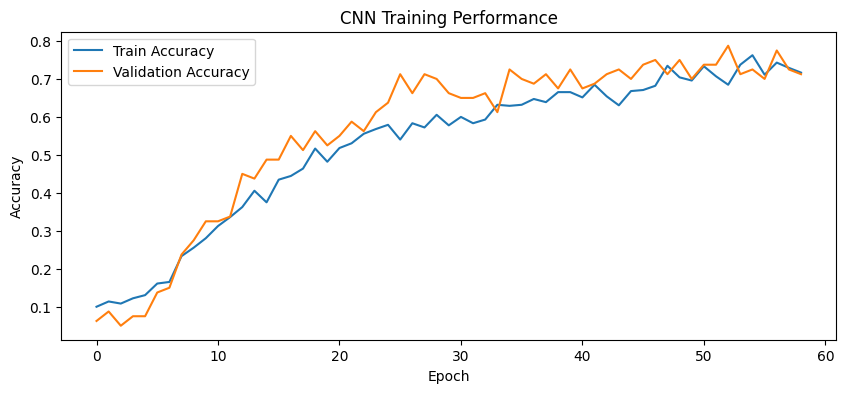

In [20]:
if __name__ == "__main__":
    X, y, label_names = load_data(FEATURES_FILE)
    
    if X is None or y is None:
        exit()

    X_train_val, X_test, y_train_val, y_test, num_classes = preprocess_and_split(X, y)
    input_shape = X_train_val.shape[1:]
    
    model = build_cnn_model(input_shape, num_classes)
    
    # --- Training the Model ---
    
    # Use ModelCheckpoint to save the *best* model based on validation loss
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            MODEL_FILENAME, 
            monitor='val_loss', 
            save_best_only=True, 
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, # Wait 10 epochs for improvement before stopping
            verbose=1,
            restore_best_weights=True # Restore the best weights found
        )
    ]
    
    history = model.fit(
        X_train_val, y_train_val,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        # Your validation_split logic (25% of remaining data)
        validation_split=VALIDATION_SPLIT,
        callbacks=callbacks,
        verbose=1
    )
    
    # Load the best model saved by the callback for final evaluation
    try:
        best_model = load_model(MODEL_FILENAME)
        print(f"\nModel reloaded from {MODEL_FILENAME} for final test evaluation.")
    except Exception as e:
        print(f"\nCould not load best model; using last epoch model. Error: {e}")
        best_model = model

    print("\n--- Evaluating Model on Test Set ---")
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\n✅ Test Accuracy (Clean Data): {accuracy*100:.2f}%")
    print(f"Loss: {loss:.4f}")

    # Save training history (all metrics)
    np.savez(
        HISTORY_FILENAME, 
        accuracy=history.history['accuracy'], 
        val_accuracy=history.history['val_accuracy'],
        loss=history.history['loss'],
        val_loss=history.history['val_loss']
    )
    print(f"Training history saved to {HISTORY_FILENAME}")

    # --- Plotting History ---
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('CNN Training Performance')
    plt.legend()
    plt.show()
